# Activation maximization

This notebook will guide you through the use of a widely used technique for studying the behaviour of convolutional neural networks. You will use a python package called `keras-vis` to apply a technique called `activation maximization`:

The idea behind activation maximization is simple: generate an input image that maximizes the output activations of a given unit (filter) in the network.

The `keras-vis` package computes the derivative of the ActivationMaximization loss with respect to the input, and uses this gradient to update the input image. ActivationMaximization loss simply outputs small values for large filter activations (the package minimizes losses during gradient descent iterations). This allows us to understand what sort of input patterns activate a particular filter. For example, for detecting the digit one (1) there could be a filter that activates for the presence of vertical lines within the input image.

For the experiments, you are going to use the `mnist` dataset from LeCun et al. 1998.

------------------------------------------------
# First part: Creating a model

## Loading the packages

In [1]:
import sys
sys.setrecursionlimit(10000)

In [2]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [3]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

In [4]:
import numpy as np
from matplotlib import pyplot as pl

from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats
from tensorflow.keras import models
from tensorflow.keras import layers

%matplotlib inline

## Loading the data

Load the `mnist` dataset and normalize in the range [0, 1]

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

11501568/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


## Creating the network

Create the CNN and show its architecture

In [6]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Conv2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(25, activation='relu', name='l4')(flat)

l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(inputs=l0, outputs=l5)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (InputLayer)             [(None, 28, 28, 1)]       0         
                                                                 
 l1 (Conv2D)                 (None, 28, 28, 9)         234       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 9)         0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 9)         2034      
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 9)           0         
                                                                 
 l3 (Conv2D)                 (None, 7, 7, 16)          1312      
                                                                 
 l3_mp (MaxPooling2D)        (None, 3, 3, 16)          0     

## Training the network

Define some constants and train de CNN

In [7]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.8413

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 18s 302us/sample - loss: 0.5272 - accuracy: 0.8413 - val_loss: 0.1701 - val_accuracy: 0.9485
Epoch 2/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.1593 - accuracy: 0.9513 - val_loss: 0.1296 - val_accuracy: 0.9609
Epoch 3/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.1085 - accuracy: 0.9659 - val_loss: 0.0785 - val_accuracy: 0.9746
Epoch 4/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0843 - accuracy: 0.9738 - val_loss: 0.0662 - val_accuracy: 0.9794
Epoch 5/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0707 - accuracy: 0.9782 - val_loss: 0.0589 - val_accuracy: 0.9807
Epoch 6/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0609 - accuracy: 0.9810 - val_loss: 0.0581 - val_accuracy: 0.9812
Epoch 7/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0533 - accuracy: 0.9835 - val_lo

Show the performance of the model

Test score: 0.04586550705607515
Test accuracy: 0.9864


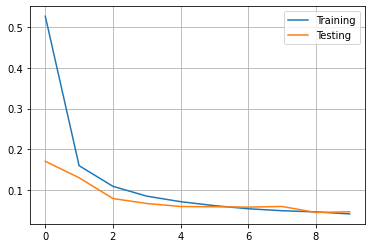

In [8]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [9]:
pred = model.predict_on_batch(X_test)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[ 975,    0,    3,    0,    0,    1,    0,    1,    0,    0],
       [   0, 1130,    1,    1,    0,    0,    1,    1,    1,    0],
       [   3,    1, 1022,    1,    0,    0,    0,    3,    2,    0],
       [   0,    0,    1,  997,    0,    6,    0,    2,    4,    0],
       [   1,    0,    1,    0,  977,    0,    0,    1,    1,    1],
       [   1,    0,    0,    3,    0,  885,    1,    1,    1,    0],
       [   9,    2,    2,    0,    4,    5,  934,    0,    2,    0],
       [   1,    2,    7,    1,    0,    0,    0, 1012,    1,    4],
       [   1,    0,    2,    3,    1,    2,    2,    4,  957,    2],
       [   3,    3,    2,    1,   11,    5,    0,    6,    3,  975]])

-------------------------
# Second part: maximizing activations

## Loading the packages

In [10]:
!pip install git+https://github.com/SimWalther/keras-vis.git -U

  Cloning https://github.com/SimWalther/keras-vis.git to /tmp/pip-req-build-dww2ulms
  Running command git clone -q https://github.com/SimWalther/keras-vis.git /tmp/pip-req-build-dww2ulms
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38741 sha256=b15438f78d1601ef313508c3a2f86ce440cdea3d2828781b838a9e994f752bdf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ae7y2e97/wheels/b9/b1/cc/4871a344ed370364fdc4c1c6fad6dcba51134424d065227648
Successfully built keras-vis
  Attempting uninstall: keras-vis
    Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [11]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from __future__ import print_function

In [12]:
from vis.utils import utils
from vis.visualization import visualize_cam, overlay

In [13]:
pip install -I scipy==1.2.*

     |████████████████████████████████| 24.8 MB 54.8 MB/s 
     |████████████████████████████████| 15.7 MB 40.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Activation maximization keeping the softmax activation at the output
Activation maximization does not work if the activation function is a Softmax. Let us see this behaviour

In [14]:
# select the last layer
layer_idx = utils.find_layer_idx(model, 'l5')

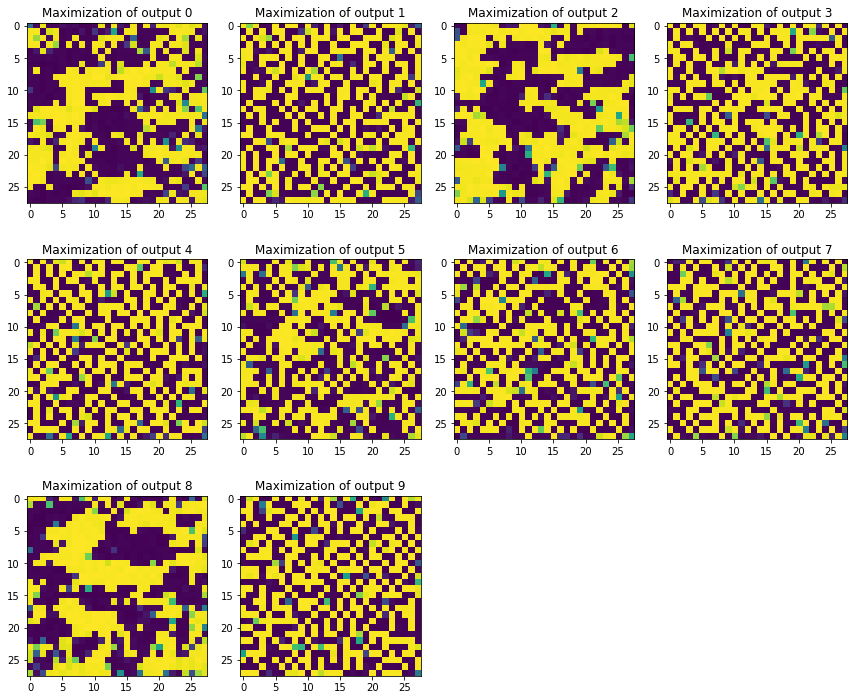

In [15]:
pl.figure(figsize=(12,10))
for output_idx in np.arange(10):
    img = visualize_activation(model, layer_idx, filter_indices=int(output_idx), input_range=(0.0, 1.0))
    pl.subplot(3, 4, output_idx+1)
    pl.title('Maximization of output {}'.format(output_idx))
    pl.imshow(img[..., 0])
pl.tight_layout()

It does not work! The reason is that when using Softmax as activation function, maximizing an output node can be done by minimizing other outputs. It is the only activation that depends on other node output(s) in the layer.

## Activation maximization without the softmax activation at the output

The following cell replaces the Softmax activation function by a Linear activation function

In [16]:
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Visualize the image that maximizes the first output (0) of the network

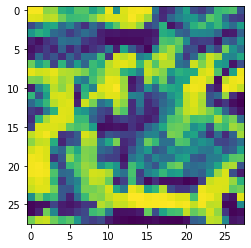

In [17]:
img = visualize_activation(model, layer_idx, filter_indices=0, input_range=(0.0, 1.0), tv_weight=0)
pl.imshow(img[..., 0])

The last result was found without using the `tv_weight` regularizer (tv_weight=0.0). However, we know that using the parameter tv_weight makes the generated image more realistic.

## Questions

<div class="alert alert-block alert-info">
<ul>
    <li>Test different values of `tv_weight`</li>
    <ul>
        <li>Try values between 0.1 and 20 (for example: [0.125, 0.25, 0.5, 1, 2, 4, 8, 16])</li>
        <li>Select the regularization parameter that gives the best images (more realistic)</li>
        <li>Show the images that maximize each one of the outputs of the network</li>
    </ul>
    <li>Maximize two outputs at the same time (filter_indices=[f1, f2])</li>
    <ul>
        <li>Try two classes with similar shape like 1 and 7 or 4 and 9</li>
        <li>Try two classes with very different shapes like 0 and 1 or 7 and 8</li>
        <li>How activation maximization can be useful for understanding a deep neural network? Explain</li>
    </ul>
</ul>
</div>